## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [56]:
!pip3 install nltk numpy pandas sklearn tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2369 sha256=fa48e8df6d96d7205d110de0430a6dd115988f5f41f6d495e9ba50e9c3b9fcb6
  Stored in directory: /Users/jaa/Library/Caches/pip/wheels/9e/9e/4c/184e84f4ce918378a9ec9adafd1b6b73bea45f0a4a7855b6ce
Successfully built sklearn
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


## importing stuff

In [3]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('../data/reviews.txt', header=None)
labels = pd.read_csv('../data/labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())
print(labels.head())
print(reviews.describe())
print(labels.describe())

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...
          0
0  positive
1  negative
2  positive
3  negative
4  positive
                                                        0
count                                               25000
unique                                              24902
top     this show comes up with interesting locations ...
freq                                                    3
               0
count      25000
unique         2
top     positive
freq       12500


In [58]:
percentage = int(len(reviews) * 0.25)

reviews_slim = reviews.iloc[:percentage]
labels_slim = labels.iloc[:percentage]
Y_slim = Y.iloc[:percentage]

# Checking the results
print(f"Original size: {len(reviews)}")
print(f"Slimmed down size: {len(reviews_slim)}")

print(reviews_slim.describe())
print(labels_slim.describe())

Original size: 25000
Slimmed down size: 6250
                                                        0
count                                                6250
unique                                               6238
top     when i got this movie free from my job  along ...
freq                                                    3
               0
count       6250
unique         2
top     positive
freq        3125


In [59]:
reviews_slim.to_csv('../exports/reviews_slim.csv', index=True)
labels_slim.to_csv('../exports/labels_slim.csv', index=True)

## **(a)** Split the reviews and labels in test, train and validation sets. 


The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [60]:
# combining the data to make it easier to work with before splitting again

# Remove any unnamed index columns if they exist
reviews.columns = reviews.columns.astype(str)
labels.columns = labels.columns.astype(str)

reviews = reviews.loc[:, ~reviews.columns.str.contains('^Unnamed')]
labels = labels.loc[:, ~labels.columns.str.contains('^Unnamed')]

# Concatenate the two dataframes along the columns
combined_df = pd.concat([reviews, labels], axis=1)

# Rename the columns for clarity
combined_df.columns = ['Review', 'Sentiment']


print(combined_df.head())
print(combined_df.describe())

                                              Review Sentiment
0  bromwell high is a cartoon comedy . it ran at ...  positive
1  story of a man who has unnatural feelings for ...  negative
2  homelessness  or houselessness as george carli...  positive
3  airport    starts as a brand new luxury    pla...  negative
4  brilliant over  acting by lesley ann warren . ...  positive
                                                   Review Sentiment
count                                               25000     25000
unique                                              24902         2
top     this show comes up with interesting locations ...  positive
freq                                                    3     12500


In [61]:
# text preprocessing - tokenisation, removing stop words, lemmatising 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/jaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jaa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review,Sentiment,Processed_Review
0,bromwell high is a cartoon comedy . it ran at ...,positive,bromwell high cartoon comedy ran time program ...
1,story of a man who has unnatural feelings for ...,negative,story man unnatural feeling pig start opening ...
2,homelessness or houselessness as george carli...,positive,homelessness houselessness george carlin state...
3,airport starts as a brand new luxury pla...,negative,airport start brand new luxury plane loaded va...
4,brilliant over acting by lesley ann warren . ...,positive,brilliant acting lesley ann warren best dramat...


In [ ]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply the preprocessing to each review
preprocessed_df = combined_df.copy()

preprocessed_df['Processed_Review'] = preprocessed_df['Review'].apply(preprocess_text)

preprocessed_df.head()

In [62]:
percentage = int(len(preprocessed_df) * 0.25)

preprocessed_df_slim = preprocessed_df.iloc[:percentage]
Y_slim = Y.iloc[:percentage]

# Checking the results
print(f"Original size: {len(preprocessed_df)}")
print(f"Slimmed down size: {len(preprocessed_df_slim)}")

preprocessed_df_slim.to_csv('../exports/reviews_slim_combined_preprocessed.csv', index=False)

Original size: 25000
Slimmed down size: 6250


In [63]:
# Vectorisation

from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF Vectorizer instance
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the preprocessed reviews
X = tfidf_vectorizer.fit_transform(preprocessed_df['Processed_Review'])

# Checking the shape of the resulting matrix
X

<25000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2148673 stored elements in Compressed Sparse Row format>

In [64]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encoding the sentiment labels
y = label_encoder.fit_transform(preprocessed_df['Sentiment'])

# Checking the first few encoded labels
y[:5]

array([1, 0, 1, 0, 1])

In [65]:
# Train / Validation / Test split

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shapes of the splits
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Checking the shapes of the new splits
print(X_train.shape, X_val.shape, X_test.shape) 
print(y_train.shape, y_val.shape, y_test.shape)

(16000, 5000) (4000, 5000) (5000, 5000)
(16000,) (4000,) (5000,)


In [67]:
# Redoing the train/validate/test split directly on the DataFrame to maintain indices
# this is an alternative (the way the assignment says the features/labels should be created)

from sklearn.feature_extraction.text import CountVectorizer

preprocessed_df['Sentiment'] = preprocessed_df['Sentiment'].map({'positive': 1, 'negative': 0})

train_df, test_df = train_test_split(preprocessed_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Apply CountVectorizer
count_vectorizer = CountVectorizer(max_features=10000)

# Fit the vectorizer on the training data and transform the training, validation, and test data
X_train_bow = count_vectorizer.fit_transform(train_df['Processed_Review'])
X_val_bow = count_vectorizer.transform(val_df['Processed_Review'])
X_test_bow = count_vectorizer.transform(test_df['Processed_Review'])

# Also, get the labels for the train, validation, and test sets
y_train = train_df['Sentiment']
y_val = val_df['Sentiment']
y_test = test_df['Sentiment']

# Checking the shape of the resulting matrices and label vectors
(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape, y_train.shape, y_val.shape, y_test.shape)


((16000, 10000), (4000, 10000), (5000, 10000), (16000,), (4000,), (5000,))

In [74]:
X_train = X_train_bow
X_val = X_val_bow
X_test = X_test_bow

# The model needs this
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()
X_test_dense = X_test.toarray()

## **(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [7]:
reviews

,0
0,bromwell high is a cartoon comedy . it ran at ...
1,story of a man who has unnatural feelings for ...
2,homelessness or houselessness as george carli...
3,airport starts as a brand new luxury pla...
4,brilliant over acting by lesley ann warren . ...
...,...
24995,i saw descent last night at the stockholm fi...
24996,a christmas together actually came before my t...
24997,some films that you pick up for a pound turn o...
24998,working class romantic drama from director ma...


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()

review_texts = reviews[0]

vectorizer.fit(review_texts)

# For a single word
word = "example"
word_vector = vectorizer.transform([word])

# For a whole review
review = "This is an example review text."
review_vector = vectorizer.transform(review_texts)

# You can then print or visualize the vectors to explore the representation
print(word_vector.toarray())
print(review_vector.toarray())

[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


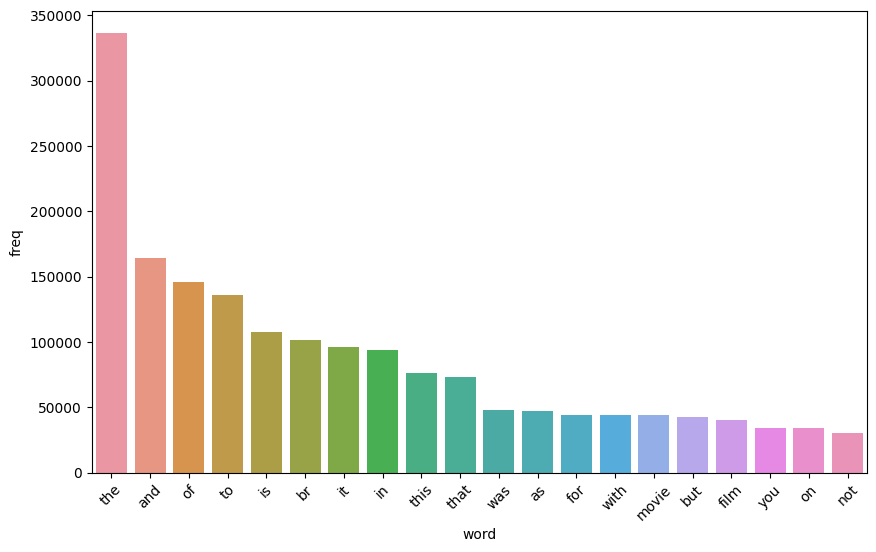

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sum up the counts of each vocabulary item
sum_words = review_vector.sum(axis=0) 

# Connect the sums with the vocabulary
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Convert to DataFrame for easy plotting
df_words = pd.DataFrame(words_freq, columns=['word', 'freq'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='freq', data=df_words.head(20))
plt.xticks(rotation=45)
plt.show()


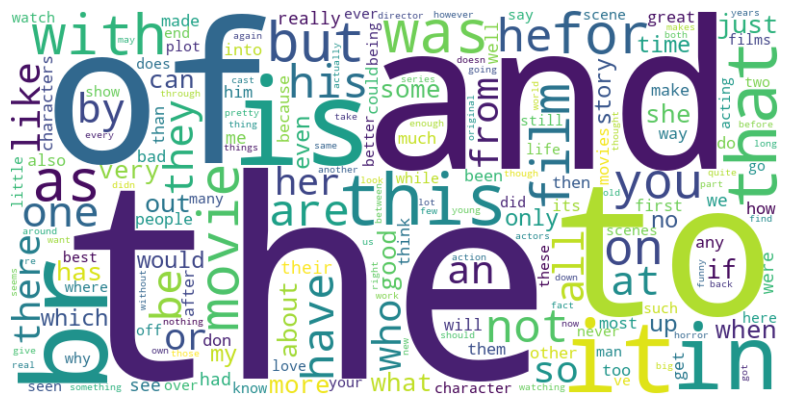

In [14]:
from wordcloud import WordCloud

# Generate a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=200).generate_from_frequencies(dict(words_freq))

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [17]:
# Statistically the most frequent sentence assembled from the most used words

from nltk.corpus import stopwords

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Get the most frequent words excluding stopwords
filtered_words = [word for word in sorted_freq_dict if word not in stop_words]

# Construct a sentence - this is arbitrary and for demonstration
most_freq_sentence = ' '.join(filtered_words[:10])
print("Most Frequent Sentence:", most_freq_sentence)


Most Frequent Sentence: br movie film one like good time even would story


## **(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [112]:
# Training

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy

# Building the model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=10000, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with the learning rate scheduler as a callback
history = model.fit(X_train_dense, y_train, epochs=25, batch_size=64, validation_data=(X_val_dense, y_val), verbose=1)


Epoch 1/25
250/250 [==============================] - 4s 13ms/step - loss: 1.1152 - accuracy: 0.8265 - val_loss: 0.7791 - val_accuracy: 0.8480
Epoch 2/25
250/250 [==============================] - 3s 13ms/step - loss: 0.8053 - accuracy: 0.8421 - val_loss: 0.8182 - val_accuracy: 0.8543
Epoch 3/25
250/250 [==============================] - 3s 12ms/step - loss: 0.8103 - accuracy: 0.8475 - val_loss: 0.7693 - val_accuracy: 0.8565
Epoch 4/25
250/250 [==============================] - 3s 12ms/step - loss: 0.8069 - accuracy: 0.8481 - val_loss: 0.7948 - val_accuracy: 0.8650
Epoch 5/25
250/250 [==============================] - 3s 13ms/step - loss: 0.7985 - accuracy: 0.8509 - val_loss: 0.7610 - val_accuracy: 0.8558
Epoch 6/25
250/250 [==============================] - 3s 13ms/step - loss: 0.7798 - accuracy: 0.8519 - val_loss: 0.8162 - val_accuracy: 0.8587
Epoch 7/25
250/250 [==============================] - 3s 12ms/step - loss: 0.7832 - accuracy: 0.8531 - val_loss: 0.7760 - val_accuracy: 0.8685

In [104]:
# Continue training the model for additional epochs
additional_epochs = 10 
history_continued = model.fit(X_train_dense, y_train, epochs=additional_epochs, batch_size=64, validation_data=(X_val_dense, y_val), verbose=1)

Epoch 1/10
250/250 [==============================] - 5s 19ms/step - loss: 0.5942 - accuracy: 0.8895 - val_loss: 0.6494 - val_accuracy: 0.8745
Epoch 2/10
250/250 [==============================] - 5s 19ms/step - loss: 0.6007 - accuracy: 0.8886 - val_loss: 0.6605 - val_accuracy: 0.8687
Epoch 3/10
250/250 [==============================] - 5s 20ms/step - loss: 0.5924 - accuracy: 0.8917 - val_loss: 0.6449 - val_accuracy: 0.8740
Epoch 4/10
250/250 [==============================] - 5s 20ms/step - loss: 0.6000 - accuracy: 0.8881 - val_loss: 0.6692 - val_accuracy: 0.8600
Epoch 5/10
250/250 [==============================] - 5s 20ms/step - loss: 0.5784 - accuracy: 0.8921 - val_loss: 0.6406 - val_accuracy: 0.8737
Epoch 6/10
250/250 [==============================] - 5s 19ms/step - loss: 0.5739 - accuracy: 0.8913 - val_loss: 0.6321 - val_accuracy: 0.8748
Epoch 7/10
250/250 [==============================] - 4s 18ms/step - loss: 0.5822 - accuracy: 0.8885 - val_loss: 0.6456 - val_accuracy: 0.8733

## **(d)** Test your sentiment-classifier on the test set.

In [113]:
# Testing
# Evaluate the model on the validation set
test_loss, test_accuracy = model.evaluate(X_test_dense, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# first try (20 epochs)
# Test Loss: 0.6639389395713806
# Test Accuracy: 0.8687499761581421

# second try with exponential LR (actually lowered the score a bit)
# Validation Loss: 1.0084891319274902
# Validation Accuracy: 0.8654000163078308

# 3. tried a more gradual custom LR - even lower
# Test Loss: 1.0994940996170044
# Test Accuracy: 0.8503999710083008

# 4. removing custom LR and changing the l2 value Dense(512, activation='relu', input_dim=10000, kernel_regularizer=l2(0.01)) (now with 25 epochs)
# Test Loss: 0.6812025904655457
# Test Accuracy: 0.8708000183105469

# 5. doubling the neurons model.add(Dense(1024, activation='relu', input_dim=10000, kernel_regularizer=l2(0.01))) - 25 epochs
# Test Loss: 0.6491168737411499
# Test Accuracy: 0.8687999844551086
# so a little bit lower score actually but it seemed to ramp up in the later epochs, so im going to continue for 10 more

# 5. with 10 more epochs: 
# Test Loss: 0.6418853998184204
# Test Accuracy: 0.8669999837875366
# not much better - lets try 10 more
# now even a little bit lower

# 6. changing the l2 regularizer - model.add(Dense(1024, activation='relu', input_dim=10000, kernel_regularizer=l2(0.03))) (35epochs)
# Test Loss: 0.7511987090110779
# Test Accuracy: 0.8569999933242798
# score lowering - lets try 0.01 regularizer and more neurons

# 7. with more neurons the accuracy has improved but not from the 512 with same l2 - 
# model.add(Dense(2048, activation='relu', input_dim=10000, kernel_regularizer=l2(0.01)))
# Test Loss: 0.6616639494895935
# Test Accuracy: 0.8708000183105469

# 8. increased regularizer to 0.03 decreased accuracy
# Test Loss: 0.7975600361824036
# Test Accuracy: 0.8597999811172485

# concluding from this - the -Dense(512, activation='relu', input_dim=10000, kernel_regularizer=l2(0.01)) - model is the best performance/training burden ratio
# Test Loss: 0.6782421469688416
# Test Accuracy: 0.8736000061035156

157/157 [==============================] - 1s 4ms/step - loss: 0.6782 - accuracy: 0.8736
Test Loss: 0.6782421469688416
Test Accuracy: 0.8736000061035156


## **(e)** Use the classifier to classify a few sentences you write yourselves. 

In [121]:
# Testing on own stuff

def predict_sentiment(text):
    processed_text = preprocess_text(text)

    vectorized_text = count_vectorizer.transform([processed_text]).toarray()

    prediction = model.predict(vectorized_text)

    sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
    confidence = prediction[0][0] if sentiment == "positive" else 1 - prediction[0][0]

    return sentiment, confidence

In [120]:
sentences = [ 
        "I really enjoyed this movie!",
        "This movie was an absolute masterpiece, with stunning visuals and a gripping story.",
        "I found the film to be incredibly boring and a waste of time.",
        "The acting was mediocre at best and the plot was predictable.",
        "An exhilarating and heartwarming adventure I would watch again!",
        "Not bad, but not particularly memorable or innovative.",
    ]

for sentence in sentences:
    predicted_sentiment, confidence = predict_sentiment(sentence)
    print(f"The predicted sentiment for \"{sentence}\" is {predicted_sentiment} with a confidence of {confidence:.2f}.")

1/1 [==============================] - 0s 19ms/step
The predicted sentiment for "I really enjoyed this movie!" is positive with a confidence of 0.74.
1/1 [==============================] - 0s 12ms/step
The predicted sentiment for "This movie was an absolute masterpiece, with stunning visuals and a gripping story." is positive with a confidence of 0.77.
1/1 [==============================] - 0s 11ms/step
The predicted sentiment for "I found the film to be incredibly boring and a waste of time." is negative with a confidence of 0.89.
1/1 [==============================] - 0s 13ms/step
The predicted sentiment for "The acting was mediocre at best and the plot was predictable." is negative with a confidence of 0.61.
1/1 [==============================] - 0s 11ms/step
The predicted sentiment for "An exhilarating and heartwarming adventure I would watch again!" is positive with a confidence of 0.62.
1/1 [==============================] - 0s 11ms/step
The predicted sentiment for "Not bad, but 